# VLSE Curves and Datapoint Generation for MD Simulation

Importing Modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns
from matplotlib.widgets import SpanSelector
import math
import scipy

User options

In [3]:
include_2019_data = False # Includes 2019 data in graphs, no effect on curve fits
triple_point_tolerance = 1*10**(-10) # Solver tolerence for finding triple point
desired_number_of_sobol_points = 1500 # The actual number of sobol points is this number rounded to the nearest 2^n where n -> intiger 

Instantiating data

In [4]:
vle_temp_2019_data = np.array([0.4,0.41,0.42,0.43,0.44])
inverse_gas_density_2019_data = np.array([35.40806914,28.16798258,21.91249159,16.245217,11.06553708])
inverse_liq_density_2019_data = np.array([1.331229281,1.361101621,1.39302346,1.436343071,1.480891538])
vle_density_gas_2019_data = np.reciprocal(inverse_gas_density_2019_data)
vle_density_liq_2019_data = np.reciprocal(inverse_liq_density_2019_data)

density_f = np.array([0.786,0.801,0.829,0.856])
density_s = np.array([0.855,0.870,0.880,0.903])
T_sf = np.array([0.45,0.55,0.70,1])

critical_point_density = np.array([0.366])
critical_point_temperature = np.array([0.522])

T_gl = np.array([0.450,0.460,0.470,0.480,0.490,0.495,0.500,0.505,0.515])
density_gas = np.array([0.030, 0.036, 0.05, 0.053, 0.064, 0.07, 0.09, 0.09, 0.28])
density_liq = np.array([0.722,0.72,0.70,0.68,0.65,0.65,0.65,0.64,0.43])

T_vl = np.array([0.415,0.425,0.435,0.445,0.450,0.455,0.460,0.465,0.468])
density_gas2 = np.array([0.0163,0.0173,0.0235,0.0274,0.0285,0.0339,0.0406,0.0473,0.0420])
density_liq2 = np.array([0.763,0.757,0.738,0.725,0.712,0.706,0.698,0.695,0.603])

liq_vle_density = np.concatenate((critical_point_density,density_liq,density_liq2))
liq_vle_temp = np.concatenate((critical_point_temperature,T_gl,T_vl))
gas_vle_density = np.concatenate((density_gas2,density_gas,critical_point_density))
gas_vle_temperature = np.concatenate((T_vl,T_gl,critical_point_temperature))

vle_liq_df = pd.DataFrame({
    'Densities' : liq_vle_density,
    'Temperatures' : liq_vle_temp})
vle_liq_df_sorted = vle_liq_df.sort_values(by=['Densities'])
vle_liq_df_sorted
vle_liq_den = vle_liq_df_sorted['Densities'].to_numpy()
vle_liq_tem = vle_liq_df_sorted['Temperatures'].to_numpy()

vle_gas_df = pd.DataFrame({
    'Densities' : gas_vle_density,
    'Temperatures' : gas_vle_temperature})
vle_gas_df_sorted = vle_gas_df.sort_values(by=['Densities'])
vle_gas_den = vle_gas_df_sorted['Densities'].to_numpy()
vle_gas_tem = vle_gas_df_sorted['Temperatures'].to_numpy()

vle_densities = np.concatenate([vle_gas_den,vle_liq_den])
vle_temperatures = np.concatenate([vle_gas_tem,vle_liq_tem])

liquid_density_range = np.linspace(min(vle_liq_den),min(density_f),100)
gas_density_range = np.linspace(min(gas_vle_density),max(gas_vle_density),100)
solid_density_range = np.linspace(max(vle_liq_den),max(density_f),10000)

Fitting curves

In [5]:
def liquid_curve(x,a,b,c):
    return a*np.arctan(b*x-c)
liquid_curve_parameters,pcov2 = curve_fit(liquid_curve,vle_liq_den,vle_liq_tem,maxfev = 100000000)

def vapour_curve(x,a,b,c,d):
    return a*np.arctan(b*x-c)+d
vapour_curve_parameters,pcov1 = curve_fit(vapour_curve,vle_gas_den,vle_gas_tem,maxfev = 100000000)

def solid_curve(x,a,b,c):
    return a*np.exp(b*x)+c
solid_curve_parameters,pcov4 = curve_fit(solid_curve,density_f,T_sf,maxfev = 100000000)

Finding triple point

In [6]:
def difference_between_solid_liquid(x,fitted_solid_curve_params,fitted_liquid_curve_params):
    '''
    Calculates the difference between the temperature of the solid phase and liquid phase at a given denisity.
    When fsolve is used on this function finds the point where the liquid curve and solid curve intersect
    '''
    return solid_curve(x,*fitted_solid_curve_params)-liquid_curve(x,*fitted_liquid_curve_params)

density_triple_point = scipy.optimize.fsolve(difference_between_solid_liquid,x0 = 0.768,xtol=triple_point_tolerance,args=(solid_curve_parameters,liquid_curve_parameters))
temperature_triple_point = solid_curve(density_triple_point,*solid_curve_parameters)

# Plotting curves

Plotting VLSE

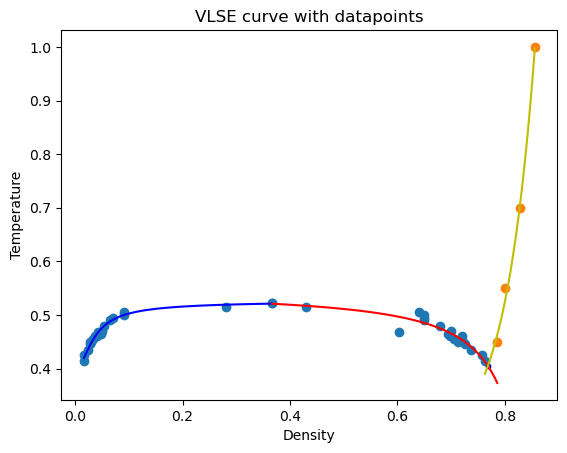

In [7]:
semi_final_fig, plots = plt.subplots()
plots.plot(gas_density_range,vapour_curve(gas_density_range,*vapour_curve_parameters),'b')
plots.plot(liquid_density_range,liquid_curve(liquid_density_range,*liquid_curve_parameters),'r')
plots.plot(solid_density_range,solid_curve(solid_density_range,*solid_curve_parameters),'y')
plots.scatter(vle_densities,vle_temperatures)
plots.scatter(density_f,T_sf)
plots.scatter(density_triple_point,temperature_triple_point,marker = 'o',edgecolor='b',s=10)
plt.title("VLSE curve with datapoints")
plt.xlabel("Density")
plt.ylabel("Temperature")
plt.show()

Plotting solid phase only

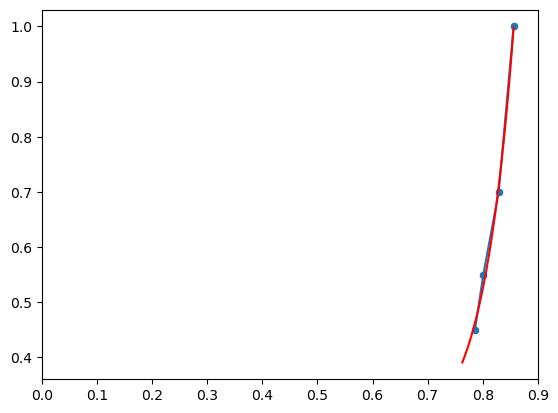

In [12]:
plt.scatter(density_f,T_sf)
plt.plot(solid_density_range,solid_curve(solid_density_range,*solid_curve_parameters),'r')
sns.scatterplot(x=density_f,y=T_sf)
plt.xlim(0.0,0.9)
plt.show()

Plotting liquid phase only

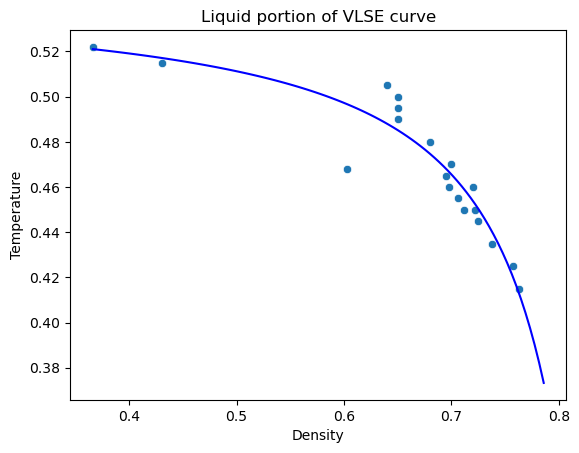

In [9]:
plt.plot(liquid_density_range,liquid_curve(liquid_density_range,*liquid_curve_parameters),'b')
sns.scatterplot(x=vle_liq_den,y=vle_liq_tem)
if include_2019_data == True:
    sns.scatterplot(x=vle_density_liq_2019_data,y=vle_temp_2019_data)
plt.title("Liquid portion of VLSE curve")
plt.xlabel("Density")
plt.ylabel("Temperature")
plt.show()

Plotting vapour phase only

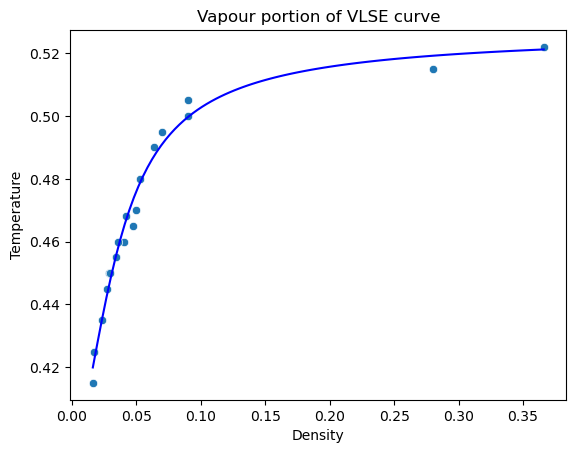

In [10]:
final_fig, phase_plot = plt.subplots()
phase_plot.plot(gas_density_range,vapour_curve(gas_density_range,*vapour_curve_parameters),'b')
sns.scatterplot(x = gas_vle_density,y=gas_vle_temperature)
if include_2019_data == True:
    sns.scatterplot(x=vle_density_gas_2019_data,y=vle_temp_2019_data)
plt.title("Vapour portion of VLSE curve")
plt.xlabel("Density")
plt.ylabel("Temperature")
plt.show()

# Datapoint Generation

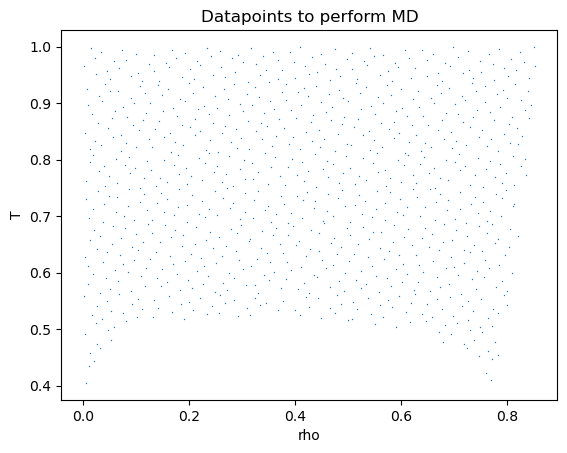

In [11]:
def num_of_sobol_points(number_of_points:int):
    """
    Rounds the number of points you input to the nearest number required to be input to the sobol sequence
    i.e.Rounds to the nearest 2^n where n is an int
    """
    exponent_of_two_to_get_required_number_of_points = math.log(number_of_points)/math.log(2)
    rounded_exponent = round(exponent_of_two_to_get_required_number_of_points,0)
    number_of_sobol_points = 2**rounded_exponent
    return int(number_of_sobol_points)

dimension = 2
points_to_generate = num_of_sobol_points(desired_number_of_sobol_points)
sobol_sequence = scipy.stats.qmc.Sobol(dimension) 
sobol_values = sobol_sequence.random(points_to_generate)

critical_density = float(critical_point_density)
triple_point_density = float(density_triple_point)

sobol_df = pd.DataFrame(sobol_values)
sobol_df.columns = ['rho','T']
sobol_df['vle_curve_value_at_rho_of_sobol_point'] = np.where(sobol_df["rho"]<critical_density,vapour_curve(sobol_df["rho"],*vapour_curve_parameters),liquid_curve(sobol_df["rho"],*liquid_curve_parameters)) # If the density of the point is less than the critical point density, use vapour equation, if not use the liquid equation
sobol_df['vle_curve_value_at_rho_of_sobol_point'] = np.where(sobol_df["rho"]>triple_point_density,solid_curve(sobol_df["rho"],*solid_curve_parameters),sobol_df['vle_curve_value_at_rho_of_sobol_point']) # If the density of the point is greater then the triple point density, use the SLE curve , if not just keep the VLE curve value
sobol_df['T_greater_than_VLE_curve'] = sobol_df["T"]>sobol_df["vle_curve_value_at_rho_of_sobol_point"] # If the temperature of the sobol point less greater than the value at the SLE-VLE curve at that density , then  True, else false

# print(sobol_df[sobol_df['T_greater_than_VLE_curve']]) # Print the dataframe where only the T_greater_thabn_VLE_curve is True

plt.clf() # clear any plots
sns.scatterplot(data = sobol_df[sobol_df['T_greater_than_VLE_curve']], x='rho',y = 'T',s=1).set(title = "Datapoints to perform MD") # Plot the points where only the T for the sobol point is greater than the value for T on the curve
plt.show()